<a href="https://colab.research.google.com/github/ianforrest11/DS-Unit-2-Regression-Classification/blob/master/module3/assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [X] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [X] Do exploratory visualizations with Seaborn.
- [X] Do one-hot encoding of categorical features.
- [X] Do feature selection with `SelectKBest`.
- [X] Fit a linear regression model with multiple features.
- [X] Get mean absolute error for the test set.
- [X] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

     |████████████████████████████████| 92kB 5.6MB/s 
     |████████████████████████████████| 133kB 14.9MB/s 
     |████████████████████████████████| 7.1MB 44.4MB/s 
     |████████████████████████████████| 614kB 43.9MB/s 
     |████████████████████████████████| 225kB 26.7MB/s 
     |████████████████████████████████| 768kB 46.1MB/s 
     |████████████████████████████████| 51kB 23.8MB/s 
     |████████████████████████████████| 194kB 44.2MB/s 
     |████████████████████████████████| 51kB 21.5MB/s 
     |████████████████████████████████| 737kB 46.4MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.3.0-py2.py3-none-any.whl size=145036 sha256=7ca4437ad897e770864a356fbd3497bfc4ec49a2d3535a78fadd89c44e63ce2c
  Stored in directory: /root/.cache/pip/wheels/ce/c7/f1/dbfef4848ebb048cb1d4a22d1ed0c62d8ff2523747235e19fe
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27085 sha256=d3ff2cd165c1a26cf6f7403d58c7a580635b1ea9f0fe1488ac3ffab1d4f26911
  Stored

In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# Convert to datetime and look at the date range
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)

**good**

In [0]:
# create subset of data for home sales between $100,000 and $2mil, building type = 01 ONE FAMILY DWELLING

mask = ((df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS') &
        (df['SALE_PRICE'] >= 100000) &
        (df['SALE_PRICE'] <= 2000000))

df= df[mask]


# create subset of data for home sales between $100,000 and $2mil
#df = df[(df['SALE_PRICE'] >= 100000) & (df['SALE_PRICE'] <= 2000000)]

**^^^^^ misunderstood expectation, did not include building class category in initial filter**

**changing code to get more familiar with 'mask' concept**

In [0]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OCEAN PARKWAY-NORTH,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,2019-01-01
61,4,QUEENS VILLAGE,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,2019-01-01
65,1,CHELSEA,13 CONDOS - ELEVATOR APARTMENTS,2,691,1130,NaN,R4,"505 WEST 19TH STREET, 7D",7D,10011.0,1.0,0.0,1.0,"18,975",1077.0,2013.0,2,R4,2000000,2019-01-02
66,1,MIDTOWN EAST,10 COOPS - ELEVATOR APARTMENTS,2,1347,18,NaN,D4,"345 EAST 54TH ST, 3B",NaN,10022.0,0.0,0.0,0.0,0,0.0,1960.0,2,D4,330000,2019-01-02
67,1,UPPER EAST SIDE (79-96),10 COOPS - ELEVATOR APARTMENTS,2,1491,62,NaN,D4,"16 EAST 80TH STREET, 2A",NaN,10075.0,0.0,0.0,0.0,0,0.0,1925.0,2,D4,600000,2019-01-02


In [53]:
# create train/test datasets by assigning cutoff date of April 1, 2019 to 'SALE_DATE' column
cutoff = pd.to_datetime('2019-04-01')
train = df[df.SALE_DATE < cutoff]
test  = df[df.SALE_DATE >= cutoff]
train.shape, test.shape

((2517, 21), (647, 21))

**^^^^^good**

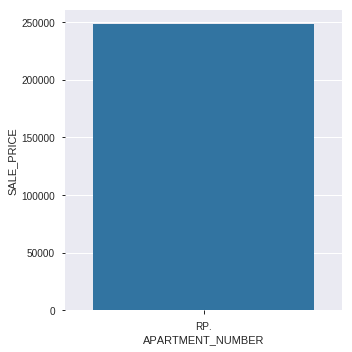

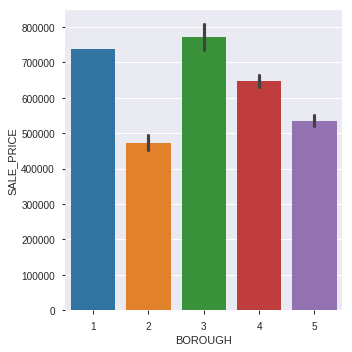

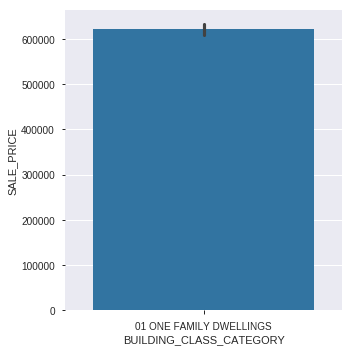

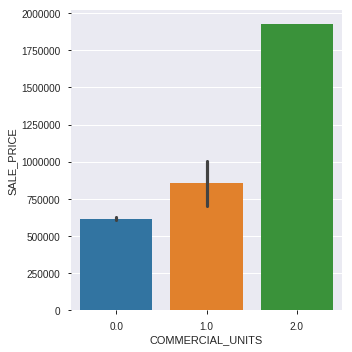

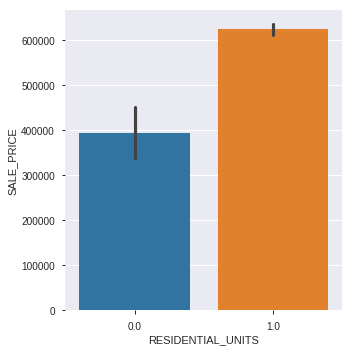

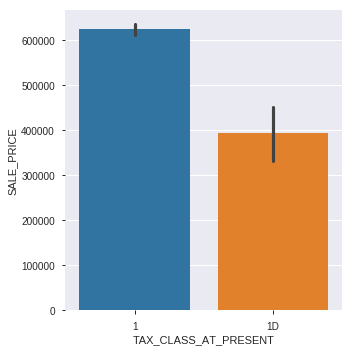

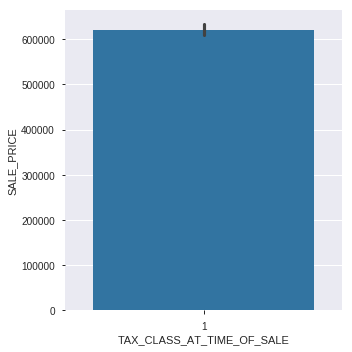

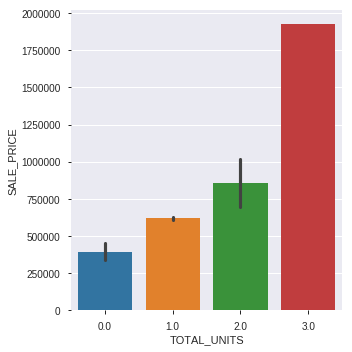

In [34]:
# exploratory visualization
for col in sorted(train.columns):
    if train[col].nunique() < 10:
      try:
        sns.catplot(x=col, y='SALE_PRICE', data=train, kind='bar')
        plt.show()
      except:
        pass



# exploratory visualization
#for col in sorted(train.columns):
#    if train[col].nunique() < 50:
#        sns.catplot(x=col, y='SALE_PRICE', data=train, kind='bar')
#        plt.show()

**^^^^wrong**

**-did not add try/except clauses for massive number of graphs that have too many variables to generate**

**-was running into error if graph had too many variables, try/except feature alleviates this error**

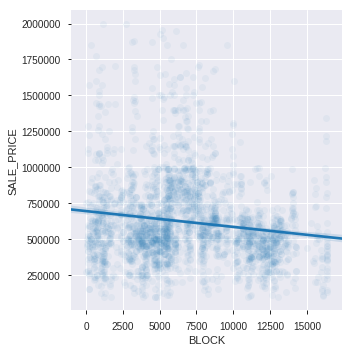

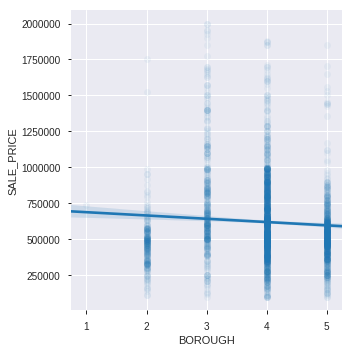

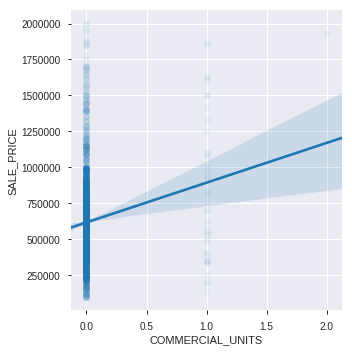

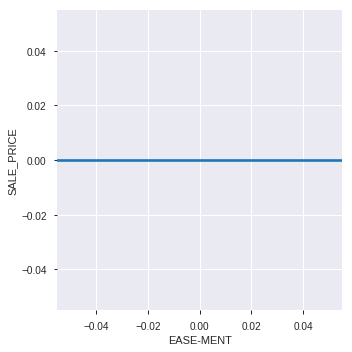

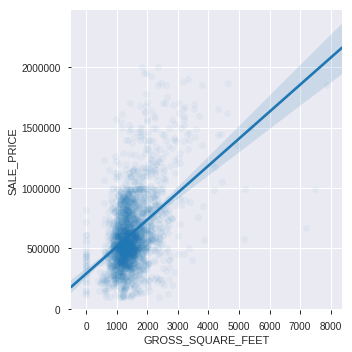

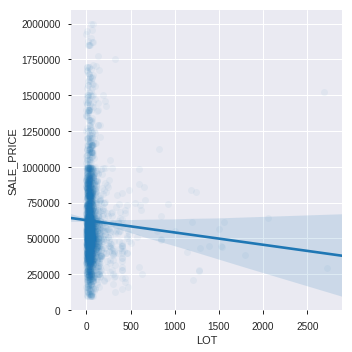

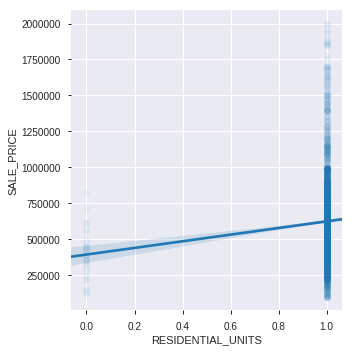

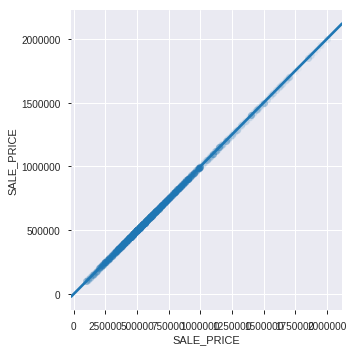

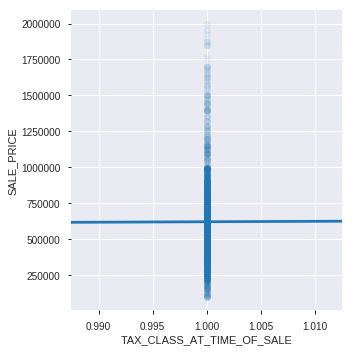

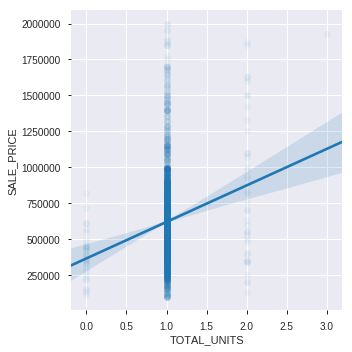

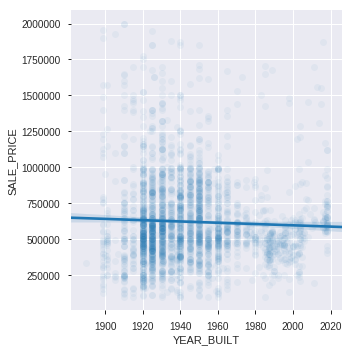

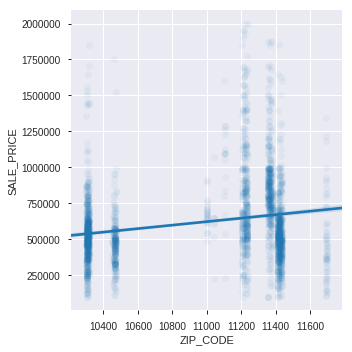

In [12]:
#did not include, added during correction phase


# additional visualizations using lmplot
numeric = train.select_dtypes('number')
for col in sorted(numeric.columns):
  sns.lmplot(x=col,y='SALE_PRICE', data=train, scatter_kws=dict(alpha=0.05))
  plt.show()

In [54]:
# change borough to categorical column
train['BOROUGH'] = train['BOROUGH'].astype(str)
test['BOROUGH'] = test['BOROUGH'].astype(str)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


**^^^^^^missed, did not realize 'borough' was numerical, changing to categorical, as value of 5 representing staten island is not worth more than 1 representing manhattan, for example**

In [55]:
# check cardinality of all non-numeric features as part of exploratory analysis
train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq,first,last
BUILDING_CLASS_CATEGORY,2517,1,01 ONE FAMILY DWELLINGS,2517,NaN,NaN
APARTMENT_NUMBER,1,1,RP.,1,NaN,NaN
TAX_CLASS_AT_PRESENT,2517,2,1,2486,NaN,NaN
BOROUGH,2517,5,4,1209,NaN,NaN
BUILDING_CLASS_AT_TIME_OF_SALE,2517,11,A1,921,NaN,NaN
BUILDING_CLASS_AT_PRESENT,2517,13,A1,921,NaN,NaN
SALE_DATE,2517,68,2019-01-31 00:00:00,78,2019-01-01 00:00:00,2019-03-30 00:00:00
NEIGHBORHOOD,2517,178,FLUSHING-NORTH,78,NaN,NaN
LAND_SQUARE_FEET,2517,889,"4,000",235,NaN,NaN
ADDRESS,2517,2507,130-52 LEFFERTS BOULEVARD,2,NaN,NaN


In [56]:
# did not include, had idea but did not know how to execute, or whether was allowed

# reduce neighborhood cardinality by replacing all neighborhoods outside the top-10 value count with 'other'
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
train['NEIGHBORHOOD'].value_counts()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


OTHER                       1914
FLUSHING-NORTH                78
GREAT KILLS                   69
ST. ALBANS                    67
SPRINGFIELD GARDENS           67
SO. JAMAICA-BAISLEY PARK      64
QUEENS VILLAGE                64
SOUTH OZONE PARK              49
MIDLAND BEACH                 49
LAURELTON                     48
BAYSIDE                       48
Name: NEIGHBORHOOD, dtype: int64

In [0]:
#train_subset = train.select_dtypes('number').dropna(axis='columns')
#test_subset  = test.select_dtypes('number').dropna(axis='columns')
#assert all(train_subset.columns == test_subset.columns)

target = 'SALE_PRICE'
numerics = train.select_dtypes(include='number').columns.drop(target).tolist() # all numeric columns except for SALE_PRICE to list
categoricals = train.select_dtypes(exclude='number').columns.tolist() # all categorical columns to list
low_cardinality_categoricals = [col for col in categoricals           # define low carinality as all categoricals with less than 50 unique values
                               if train[col].nunique() <=50]

features = numerics + low_cardinality_categoricals                    # define features as all numeric columns (except SALES_PRICE) & all low-cardinality 

# DEFINE XTRAIN YTRAIN XTEST YTEST
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

#features = train_subset.columns.drop(target)
#X_train = train_subset[features]
#y_train = train_subset[target]
#X_test  = test_subset[features]
#y_test  = test_subset[target]
#X_train.shape, y_train.shape, X_test.shape, y_test.shape

**^^^^incorrect, dropped NaN values instead of target variable, 'SALE_PRICE'**

**^^^did not define low categoricals**

In [63]:
# one-hot encoding
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)

# add encoded variables to train and test datasets, X variable
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

X_train_encoded.head()


#encoded = encoder.fit_transform(train['BUILDING_CLASS_CATEGORY'])
#encoded.head()

,BLOCK,LOT,EASE-MENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_QUEENS VILLAGE,NEIGHBORHOOD_BAYSIDE,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_LAURELTON,NEIGHBORHOOD_SO. JAMAICA-BAISLEY PARK,NEIGHBORHOOD_SPRINGFIELD GARDENS,NEIGHBORHOOD_GREAT KILLS,NEIGHBORHOOD_SOUTH OZONE PARK,NEIGHBORHOOD_MIDLAND BEACH,NEIGHBORHOOD_ST. ALBANS,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_S0,BUILDING_CLASS_AT_PRESENT_B3,APARTMENT_NUMBER_nan,APARTMENT_NUMBER_RP.,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
44,5495,801,NaN,11230.0,1.0,0.0,1.0,1325.0,1930.0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
61,7918,72,NaN,11427.0,1.0,0.0,1.0,2001.0,1940.0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
78,4210,19,NaN,10461.0,1.0,0.0,1.0,2043.0,1925.0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
108,5212,69,NaN,11226.0,1.0,0.0,1.0,2680.0,1899.0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
111,7930,121,NaN,11203.0,1.0,0.0,1.0,1872.0,1940.0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0


**^^^^^^completely wrong, attempted to implement building class = one family dwelling here instead of in initial filter**

**^^^did not properly add encoded variables to X_train & X_test**

**^^^^didnt realize it was ok to have this many columns**

In [0]:
# remove EASE-MENT column from both encoded datasets
X_train_encoded = X_train_encoded.drop(columns = ['EASE-MENT'])
X_test_encoded = X_test_encoded.drop(columns = ['EASE-MENT'])

In [65]:
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# scale x values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# run linear regression and print MAE scores for scaled  traing and test data
for k in range(1, len(X_train_encoded.columns)+1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)
    
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f'Test MAE: ${mae:,.0f} \n')

1 features
Test MAE: $185,788 

2 features
Test MAE: $184,748 

3 features
Test MAE: $184,748 

4 features
Test MAE: $183,248 

5 features
Test MAE: $184,276 

6 features
Test MAE: $184,512 

7 features
Test MAE: $177,632 

8 features
Test MAE: $167,081 

9 features
Test MAE: $166,738 

10 features
Test MAE: $165,035 

11 features
Test MAE: $166,463 

12 features
Test MAE: $166,462 

13 features
Test MAE: $165,646 

14 features
Test MAE: $165,900 

15 features
Test MAE: $163,666 

16 features
Test MAE: $165,721 

17 features
Test MAE: $165,494 

18 features
Test MAE: $165,494 

19 features
Test MAE: $165,359 

20 features
Test MAE: $165,359 

21 features
Test MAE: $165,365 

22 features
Test MAE: $165,365 

23 features
Test MAE: $165,313 

24 features
Test MAE: $165,709 

25 features
Test MAE: $165,978 

26 features
Test MAE: $165,589 

27 features
Test MAE: $9,190,241,330,521,062 

28 features
Test MAE: $165,552 

29 features
Test MAE: $165,488 

30 features
Test MAE: $100,575,309,303

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/p

Test MAE: $2,113,165,453,340,053 

37 features
Test MAE: $164,954 

38 features
Test MAE: $31,665,400,790,298,844 

39 features
Test MAE: $235,214,552,275,085,536 

40 features
Test MAE: $5,517,637,767,288,996 

41 features
Test MAE: $84,985,335,130,738,016 

42 features
Test MAE: $232,743,610,609,462,368 

43 features
Test MAE: $196,011,911,639,756,256 

44 features
Test MAE: $8,961,014,623,701,611 

45 features
Test MAE: $2,475,607,500,667,200 

46 features
Test MAE: $164,065 

47 features
Test MAE: $301,436,949,656,008,448 

48 features
Test MAE: $202,716,393,622,482,880 

49 features
Test MAE: $170,007,905,115,142,976 

50 features
Test MAE: $171,052,445,798,438,624 

51 features
Test MAE: $213,719,050,378,416,832 

52 features
Test MAE: $427,404,114,978,592 

53 features
Test MAE: $87,415,719,277,918 

54 features
Test MAE: $110,376,609,753,441,216 



/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/p

In [68]:
k = 15
selector = SelectKBest(score_func=f_regression,k=k)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)

all_names = X_train_encoded.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

print('\nFeatures not selected:')
for name in unselected_names:
    print(name)

Features selected:
BLOCK
ZIP_CODE
COMMERCIAL_UNITS
TOTAL_UNITS
GROSS_SQUARE_FEET
BOROUGH_3
BOROUGH_2
BOROUGH_5
NEIGHBORHOOD_OTHER
NEIGHBORHOOD_BAYSIDE
NEIGHBORHOOD_FLUSHING-NORTH
BUILDING_CLASS_AT_PRESENT_A5
BUILDING_CLASS_AT_PRESENT_A3
BUILDING_CLASS_AT_TIME_OF_SALE_A5
BUILDING_CLASS_AT_TIME_OF_SALE_A3

Features not selected:
LOT
RESIDENTIAL_UNITS
YEAR_BUILT
TAX_CLASS_AT_TIME_OF_SALE
BOROUGH_4
BOROUGH_1
NEIGHBORHOOD_QUEENS VILLAGE
NEIGHBORHOOD_LAURELTON
NEIGHBORHOOD_SO. JAMAICA-BAISLEY PARK
NEIGHBORHOOD_SPRINGFIELD GARDENS
NEIGHBORHOOD_GREAT KILLS
NEIGHBORHOOD_SOUTH OZONE PARK
NEIGHBORHOOD_MIDLAND BEACH
NEIGHBORHOOD_ST. ALBANS
BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS
TAX_CLASS_AT_PRESENT_1
TAX_CLASS_AT_PRESENT_1D
BUILDING_CLASS_AT_PRESENT_A9
BUILDING_CLASS_AT_PRESENT_A1
BUILDING_CLASS_AT_PRESENT_A0
BUILDING_CLASS_AT_PRESENT_A2
BUILDING_CLASS_AT_PRESENT_S1
BUILDING_CLASS_AT_PRESENT_A4
BUILDING_CLASS_AT_PRESENT_A6
BUILDING_CLASS_AT_PRESENT_A8
BUILDING_CLASS_AT_PRESENT_B2
BUILDING

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [0]:
# generate Linear Regression Model, intercept, & co-efficients
#from sklearn.linear_model import LinearRegression
#from sklearn.metrics import mean_absolute_error

#model = LinearRegression()
#model.fit(X_train_selected, y_train)
#y_pred = model.predict(X_test_selected)
#print(model.intercept_)
#print(model.coef_)

**^^^^^incorporate into KBEST step**

In [0]:
#from sklearn.preprocessing import StandardScaler

#target = 'SALE_PRICE'
#high_cardinality = ['display_address', 'street_address', 'description', 'created']
#features = train.columns.drop([target] + high_cardinality)

#X_train = train[features]
#y_train = train[target]

#X_test = test[features]
#y_test = test[target]

#encoder = ce.OneHotEncoder(use_cat_names=True)
#X_train_encoded = encoder.fit_transform(X_train)
#X_test_encoded = encoder.transform(X_test)

#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train_encoded)
#X_test_scaled = scaler.transform(X_test_encoded)

#for k in range(1, len(X_train.columns)+1):
#    print(f'{k} features')
    
#    selector = SelectKBest(score_func=f_regression, k=k)
#    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
#    X_test_selected = selector.transform(X_test_scaled)
    
#    model = LinearRegression()
#   model.fit(X_train_selected, y_train)
    
#    y_pred = model.predict(X_test_selected)
#    mae = mean_absolute_error(y_test, y_pred)
#    print(f'Test MAE: ${mae:,.0f} \n')

**^^^^^^^incorporate into KBest step**